# Additional Improvements to ANN

## Import Relevant Libraries

In [1]:
# Basic
import numpy as np
import pandas as pd
import patsy

# Data Operations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Data Visualisation
import matplotlib.pyplot as plt

# Models
from statsmodels.genmod.families import Poisson, NegativeBinomial
from statsmodels.genmod.generalized_linear_model import GLM

# Evaluation
from sklearn.metrics import r2_score

## Set Random Seed

In [170]:
SEED = 1212

## Import Data

In [171]:
# Import Data
df = pd.read_csv("data/sanitized_additional.csv")
df = df[['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP', 'OCCUR_RANGE', 'REPORT_DELAY', 'INVESTIGATION_DURATION']]
df

,DIVISION_CODE,COUNCIL_AREA_CODE,GROUP,OCCUR_RANGE,REPORT_DELAY,INVESTIGATION_DURATION
0,1,Aberdeen City,1.0,0,0,0
1,1,Aberdeen City,1.0,0,0,0
2,1,Aberdeen City,1.0,0,0,1
3,1,Aberdeenshire,3.0,0,0,0
4,1,Aberdeen City,3.0,0,0,0
...,...,...,...,...,...,...
2625959,10,South Lanarkshire,7.0,0,0,0
2625960,5,City of Edinburgh,7.0,0,1,0
2625961,1,Aberdeen City,7.0,0,50,2
2625962,5,City of Edinburgh,7.0,0,1,0


## Data Preparation

In [172]:
# Split Target and Features
x = df.drop("INVESTIGATION_DURATION", axis=1)
y = df["INVESTIGATION_DURATION"]

In [173]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)

In [174]:
# Scale Continuous
scaler = MinMaxScaler()
scaler.fit(np.array(x_train['OCCUR_RANGE']).reshape(-1, 1))

x_train['OCCUR_RANGE'] = scaler.transform(np.array(x_train['OCCUR_RANGE']).reshape(-1, 1))
x_test['OCCUR_RANGE'] = scaler.transform(np.array(x_test['OCCUR_RANGE']).reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(np.array(x_train['REPORT_DELAY']).reshape(-1, 1))
x_train['REPORT_DELAY'] = scaler.transform(np.array(x_train['REPORT_DELAY']).reshape(-1, 1))
x_test['REPORT_DELAY'] = scaler.transform(np.array(x_test['REPORT_DELAY']).reshape(-1, 1))

In [175]:
# Recombine Targets & Features
train = x_train
train['INVESTIGATION_DURATION'] = y_train

test = x_test
test['INVESTIGATION_DURATION'] = y_test

In [176]:
# Convert Data Format
formula = 'INVESTIGATION_DURATION ~ C(DIVISION_CODE) + C(COUNCIL_AREA_CODE) + C(GROUP) + OCCUR_RANGE + REPORT_DELAY'
y_train, x_train = patsy.dmatrices(formula, train, return_type='matrix')
y_test, x_test = patsy.dmatrices(formula, test, return_type='matrix')

## Helper Functions (For Visualisation)

In [177]:
def fit_scatter(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)
    plt.scatter(y_true[::10], y_pred[::10])
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')

### Poisson Regression

In [178]:
# Train Model
pos = GLM(y_train, x_train, family=Poisson())
result = pos.fit(method='bfgs')

c:\users\mezuah4\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\users\mezuah4\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [179]:
# Get Training and Test Scores
pred_train = result.predict(x_train)
pred_test = result.predict(x_test)

print("Train R2 Score: ", r2_score(y_train, pred_train))
print("Test R2 Score: ", r2_score(y_test, pred_test))

Train R2 Score:  0.02217271422818523
Test R2 Score:  0.015880174984753248


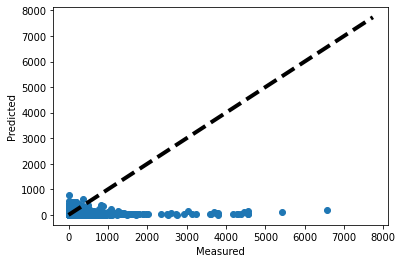

In [180]:
# Get Fit Scatter
fit_scatter(y_test, pred_test)
plt.savefig('images/additional/poisson_fit.pdf')
plt.show()

### Negative Binomial Regression

In [181]:
# Train Model
inf_pos = GLM(y_train, x_train, family=NegativeBinomial())
result2 = inf_pos.fit(method='bfgs')

c:\users\mezuah4\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\users\mezuah4\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [182]:
# Get Training and Test Scores
pred_train = result2.predict(x_train)
pred_test = result2.predict(x_test)

print("Train R2 Score: ", r2_score(y_train, pred_train))
print("Test R2 Score: ", r2_score(y_test, pred_test))

Train R2 Score:  -1781683364.2098663
Test R2 Score:  -17636504215.197292


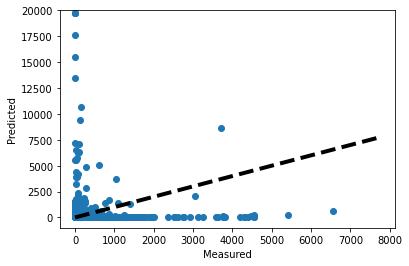

In [183]:
# Get Fit Scatter
fit_scatter(y_test, pred_test)
plt.ylim(-1000, 20000)
plt.savefig('images/additional/nb_fit.pdf')
plt.show()